In [2]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

fish-gcp005
/home/akarshkumar0101/nca-alife/src
/home/akarshkumar0101/miniconda3/envs/nca-alife-torch/bin/python


In [3]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [4]:
import experiment_utils
import util

# Create Experiment

In [110]:
! rm -rf ./experiments
! mkdir -p ./experiments

In [111]:
# img_tgt
# nca_tgt
# img_clip
# nca_clip

In [5]:
prompts = [
    "a red apple",
    # "a photo of a red apple",
    # "a green tree",
    "a very fat cat",
    "a bustling luscious nature landscape",
    "an artificial life simulation",
    # "self-replication emerging in an artificial life simulation",
    # "a photo of the emergence of open-ended complexity",
]

In [6]:
tgt_imgs = [
    "/home/akarshkumar0101/nca-alife-data/target_imgs/gorilla.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/nature.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/confetti_ball.png",
    "/home/akarshkumar0101/nca-alife-data/target_imgs/einstein.png",
]

In [21]:
group.add_argument("--seed", type=int, default=0)
group.add_argument("--save_dir", type=str, default=None)
group.add_argument("--dtype", type=str, default='float32')
group.add_argument("--device", type=str, default='cuda:0')

group = parser.add_argument_group("model")
group.add_argument("--img_size", type=int, default=224)
group.add_argument("--substrate", type=str, default='img')
# img params
group.add_argument("--init", type=str, default='randn')

# nca params
group.add_argument("--n_layers", type=int, default=2)
group.add_argument("--d_state", type=int, default=16)
group.add_argument("--d_embd", type=int, default=32)
group.add_argument("--kernel_size", type=int, default=3)
group.add_argument("--nonlin", type=str, default="GELU")

group.add_argument("--init_state", type=str, default='randn')
group.add_argument("--dt", type=float, default=0.01)
group.add_argument("--p_drop", type=float, default=0.0)
group.add_argument("--n_steps", type=int, default=64)

group = parser.add_argument_group("data")
group.add_argument("--target_img_path", type=str, default=None)
group.add_argument("--prompt", type=str, default=None)
group.add_argument("--n_augs", type=int, default=4)
group.add_argument("--augs", type=str, default="")  # crop+pers+jitter

group.add_argument("--clip_model", type=str, default="clip-vit-base-patch32") # clip-vit-base-patch32 or clip-vit-large-patch14

group = parser.add_argument_group("optimization")
group.add_argument("--bs", type=int, default=1)
group.add_argument("--lr", type=float, default=1e-3)
group.add_argument("--n_iters", type=int, default=10000)

NameError: name 'group' is not defined

In [7]:
cfg_default = dict(seed=0, save_dir=None,
                   img_size=64, substrate=None,
                   init='zeros',
                   n_layers=2, d_state=16, d_embd=32,
                   init_state='point', padding_mode='zeros', dt=0.01, p_drop=0., n_steps=64,
                   target_img_path=None,
                   prompt=None, n_augs=1, augs="",
                   bs=1, lr=1e-3, n_iters=100000)

n_seeds = 2
cfgs = []

for seed in range(n_seeds):
    for i_prompt, prompt in enumerate(prompts): # change imgsize to 224
        cfg = cfg_default.copy()
        cfg.update(seed=seed, substrate='nca', prompt=prompt, n_augs=4, augs="crop+pers", bs=4, img_size=224)
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_imgsize_{i_prompt}_{seed}")
        cfgs.append(cfg)

    for i_prompt, prompt in enumerate(prompts): # change init_state point-> randn
        cfg = cfg_default.copy()
        cfg.update(seed=seed, substrate='nca', prompt=prompt, n_augs=4, augs="crop+pers", bs=4, init_state='randn')
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_initstate_{i_prompt}_{seed}")
        cfgs.append(cfg)

    for i_prompt, prompt in enumerate(prompts): # change padding zeros-> circular
        cfg = cfg_default.copy()
        cfg.update(seed=seed, substrate='nca', prompt=prompt, n_augs=4, augs="crop+pers", bs=4, padding_mode='circular')
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_paddingmode_{i_prompt}_{seed}")
        cfgs.append(cfg)

    for i_prompt, prompt in enumerate(prompts): # change init_state point-> randn, padding zeros-> circular
        cfg = cfg_default.copy()
        cfg.update(seed=seed, substrate='nca', prompt=prompt, n_augs=4, augs="crop+pers", bs=4, init_state='randn', padding_mode='circular')
        cfg.update(save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_initstatepaddingmode_{i_prompt}_{seed}")
        cfgs.append(cfg)



In [8]:
commands = experiment_utils.create_commands(cfgs, prefix='python clip_nca_optim_torch.py', out_file='./experiments/main.sh')
print('\n'.join(commands[:3]), '\n...')
print(len(commands), 'commands')

python clip_nca_optim_torch.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_imgsize_0_0"              --img_size=224 --substrate="nca" --init="zeros" --n_layers=2 --d_state=16 --d_embd=32 --init_state="point" --padding_mode="zeros"    --dt=0.01 --p_drop=0.0 --n_steps=64 --target_img_path=None --prompt="a red apple"                          --n_augs=4 --augs="crop+pers" --bs=4 --lr=0.001 --n_iters=100000
python clip_nca_optim_torch.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_imgsize_1_0"              --img_size=224 --substrate="nca" --init="zeros" --n_layers=2 --d_state=16 --d_embd=32 --init_state="point" --padding_mode="zeros"    --dt=0.01 --p_drop=0.0 --n_steps=64 --target_img_path=None --prompt="a very fat cat"                       --n_augs=4 --augs="crop+pers" --bs=4 --lr=0.001 --n_iters=100000
python clip_nca_optim_torch.py --seed=0 --save_dir="/home/akarshkumar0101/nca-alife-data/clip_nca_op

# Visualize Results

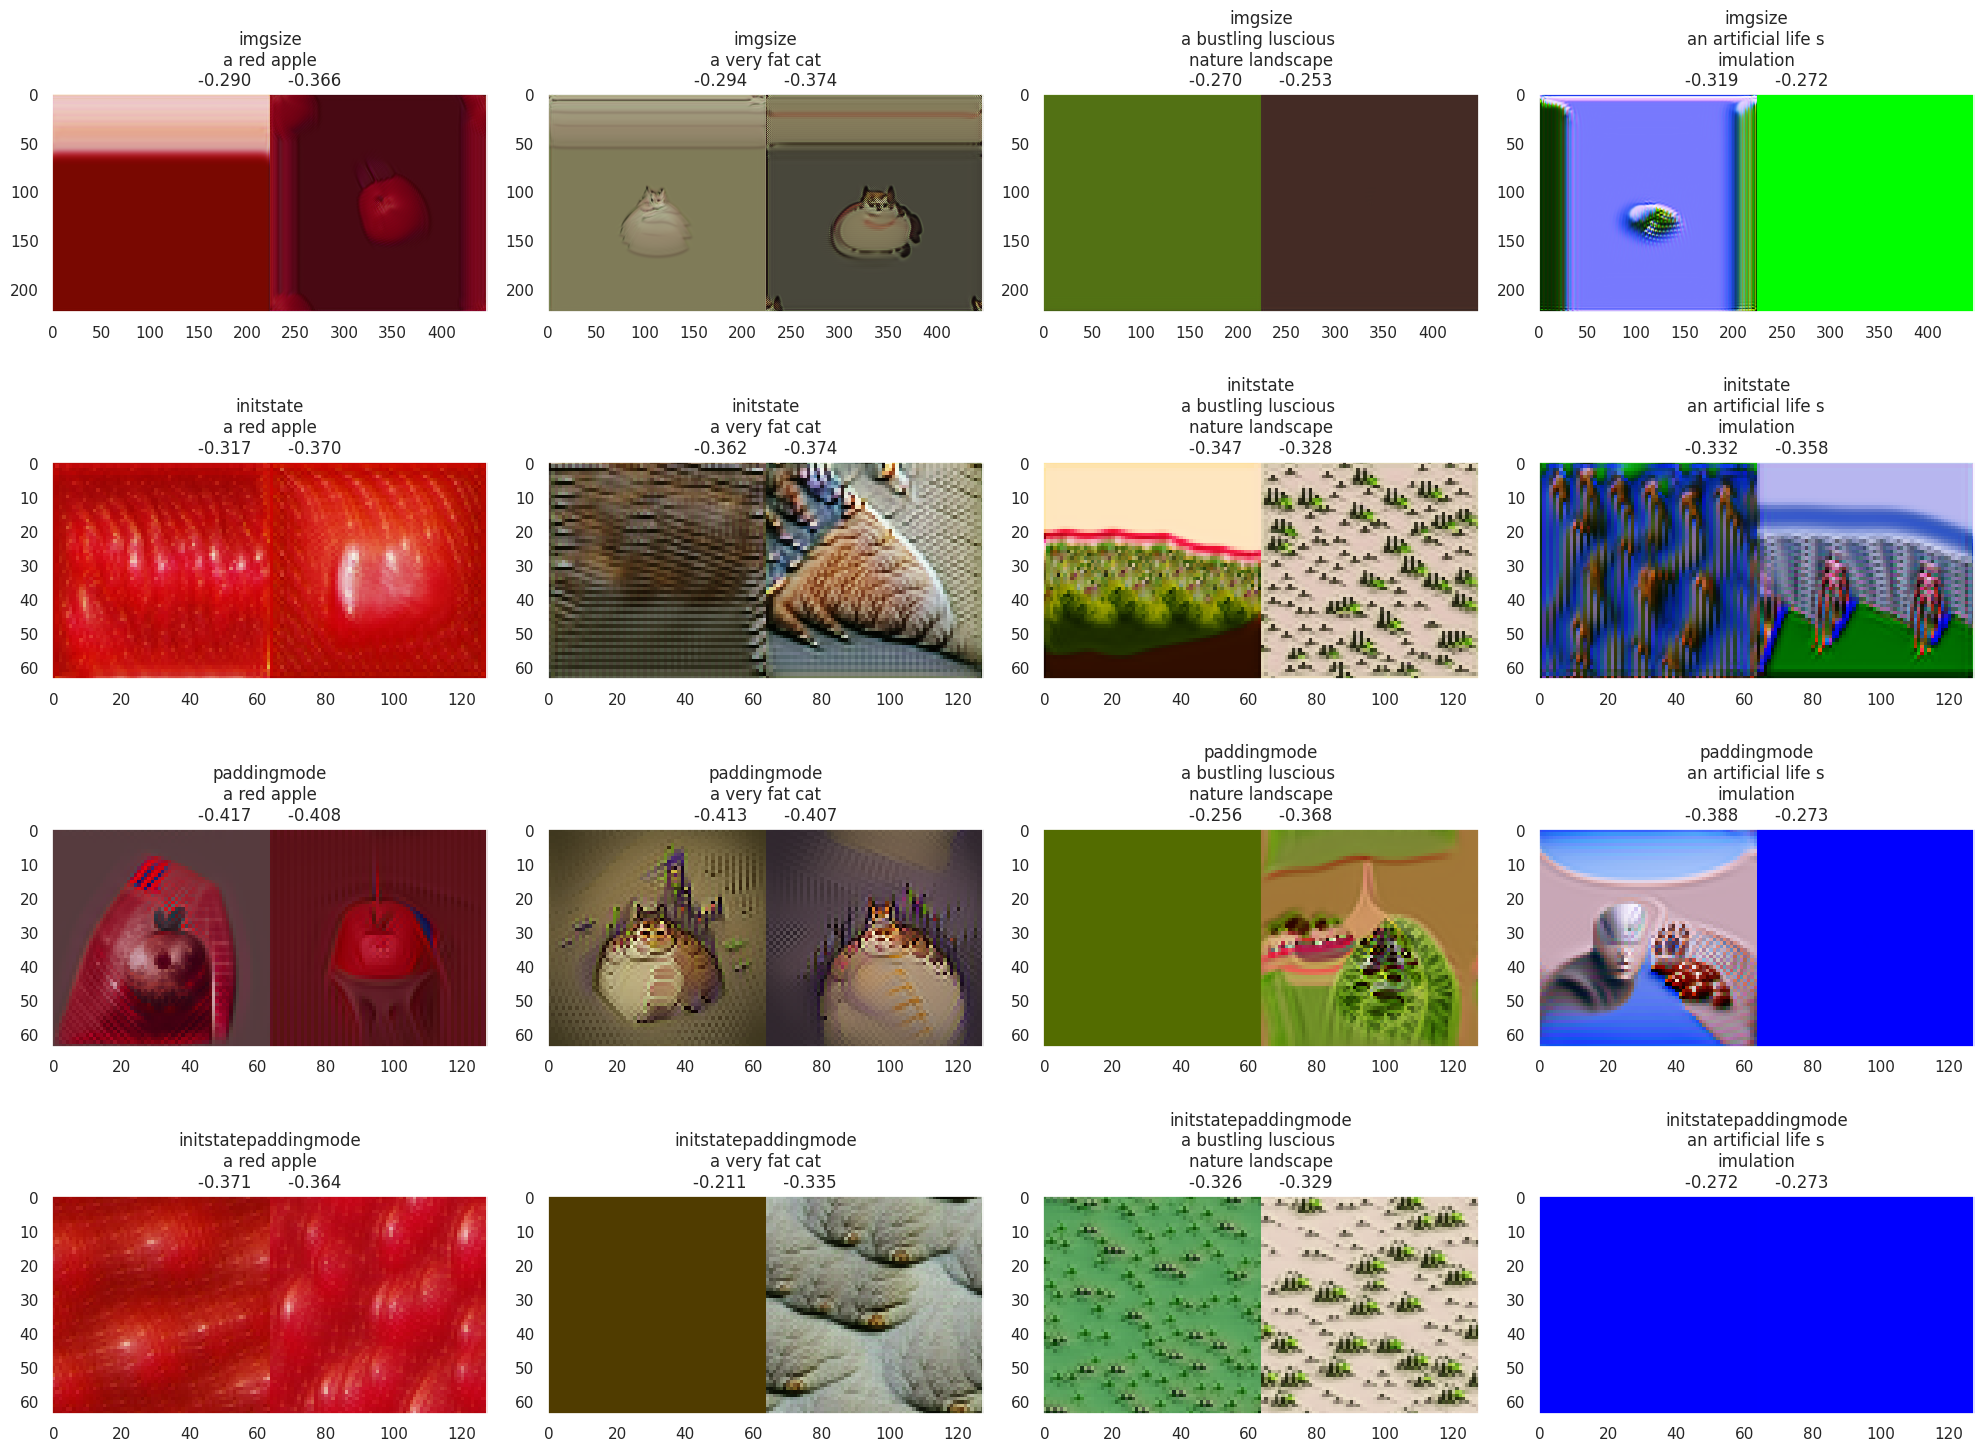

In [53]:
plt.figure(figsize=(20, 15))
i_plt = 0
for i_exp, exp in enumerate(['imgsize', 'initstate', 'paddingmode', 'initstatepaddingmode']):
    for i_prompt, prompt in enumerate(prompts): # change imgsize to 224
        imgs = []
        losses = [] 
        for seed in range(n_seeds):
            save_dir=f"/home/akarshkumar0101/nca-alife-data/clip_nca_optim_torch/nca_clip_{exp}_{i_prompt}_{seed}"
            imgs.append(util.load_pkl(save_dir, "img").astype(np.float32))
            losses.append(util.load_pkl(save_dir, 'losses')[-5000:].mean())
        i_plt += 1
        plt.subplot(4, 4, i_plt)
        plt.imshow(rearrange(imgs, 'B H W D -> H (B W) D'))
        plt.grid(False)

        prompt_display = '\n'.join([prompt[i:i+20] for i in range(0, len(prompt), 20)])
        plt.title(f"{exp}\n{prompt_display}\n{losses[0]:.3f}       {losses[1]:.3f}")
plt.tight_layout()